In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

In [6]:
npy = np.load('../E_579_dm348.8.fits.npy')

FileNotFoundError: [Errno 2] No such file or directory: '../E_579_dm348.8.fits.npy'

In [ ]:
plt.imshow(npy, aspect = 'auto')

In [ ]:
plt.plot(npy.sum(0))

In [168]:
def boxcar_kernel(width):
    """Returns the boxcar kernel of given width normalized by
    sqrt(width) for S/N reasons.

    Parameters
    ----------
    width : int
        Width of the boxcar.

    Returns
    -------
    boxcar : array_like
        Boxcar of width `width` normalized by sqrt(width).

    """
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


In [176]:
def find_burst(ts, width_factor=4, min_width=1, max_width=1024):
    """Find burst peak and width using boxcar convolution.

    Parameters
    ----------
    ts : array_like
        Time-series.
    width_factor : int, optional
        Windowing factor for on and off-pulse determination.
    min_width : int, optional
        Minimum width to search from, in number of time samples.
        1 by default.
    max_width : int, optional
        Maximum width to search up to, in number of time samples.
        128 by default.

    Returns
    -------
    peak : int
        Index of the peak of the burst in the time-series.
    width : int
        Width of the burst in number of samples.
    snr : float
        S/N of the burst.

    """
    min_width = int(min_width)
    max_width = int(max_width)

    # do not search widths bigger than timeseries
    widths = list(range(min_width,
                        min(max_width + 1, int((len(ts) - 50) // 6))))

    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)

    # borders for on and off-pulse determination
    outer = 3 * width_factor // 2
    inner = width_factor // 2

    for i in range(len(widths)):
        convolved = ss.convolve(ts, boxcar_kernel(widths[i]))
        peaks[i] = np.nanargmax(convolved)
        # peak should not be on the edge of time-series
        if (peaks[i] > 0.999 * ts.shape[0]) or (peaks[i] < 0.001 * ts.shape[0]):
            snrs[i] = np.nan
        else:
            # get RMS for S/N weighting, as in PRESTO's single_pulse_search.py
            baseline = np.concatenate(
                [
                    convolved[0 : max(0, peaks[i] - 3 * widths[i])],
                    convolved[peaks[i] + 3 * widths[i] :],
                ]
            )

            # cutoff of at least 50 samples is a bit arbitrary, but seems
            # reasonable
            if baseline.shape[0] > 50:
                rms = np.std(baseline)
            else:
                rms = np.nan

            snrs[i] = convolved[peaks[i]] / rms

    best_idx = np.nanargmax(snrs)

    return peaks[best_idx]-widths[best_idx]//2, widths[best_idx], snrs[best_idx]

In [183]:
ts = npy.sum(0)

peaks, widths, snrs = find_burst(ts)

ValueError: too many values to unpack (expected 3)

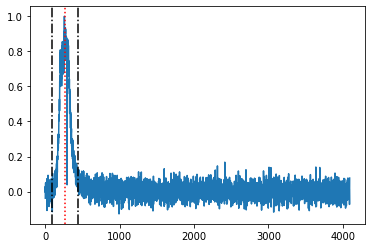

In [184]:
plt.plot(ts/np.max(ts))
plt.axvline(peaks, c = 'r', linestyle = 'dotted')
plt.axvline(peaks - widths, c = 'k', linestyle = 'dashdot')
plt.axvline(peaks + widths, c = 'k', linestyle = 'dashdot')

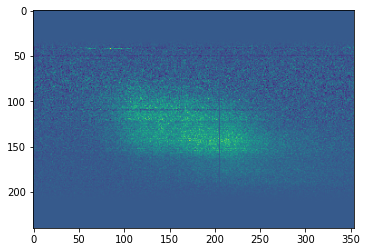

In [174]:
sub_npy = np.nanmean(npy.reshape(-1, 32, npy.shape[1]), axis=1)
plt.imshow(sub_npy[:, peaks - widths:peaks + widths])

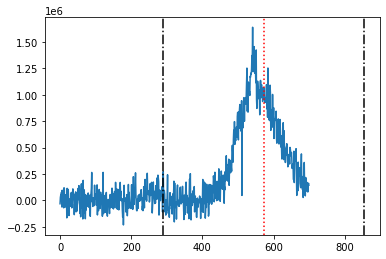

In [163]:
plt.plot(ts[2500:3200])
plt.axvline(peaks-2500, c = 'r', linestyle = 'dotted')
plt.axvline(peaks - widths - 2500, c = 'k', linestyle = 'dashdot')
plt.axvline(peaks + widths - 2500, c = 'k', linestyle = 'dashdot')